In [489]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [490]:
# Initialize weights

def initialize_weights(layer_dimensions):
    np.random.seed(42) # For reproducibility
    parameters = {}
    L = len(layer_dimensions) - 1 # Number of layers excluding input layer
    for l in range(1, L + 1):
        # The initialization for weights
        parameters[f"W{l}"] = np.random.randn(
            layer_dimensions[l], layer_dimensions[l - 1]
            ) * np.sqrt(2 / layer_dimensions[l - 1])

        # Initializing biases to zeros
        parameters[f"b{l}"] = np.zeros((layer_dimensions[l], 1))
    return parameters

In [491]:
# Activation functions

elu_alpha = 1
def elu(x):
    return np.where(x > 0, x, elu_alpha * (np.exp(x) - 1))

def softmax(x):
    shift_x = x - np.max(x, axis = 0)
    exp_x = np.exp(shift_x)
    return exp_x / np.sum(exp_x, axis = 0, keepdims = True)

In [492]:
# cross-entropy Cost function

def cost(y_hat, y):
    assert(y.shape[0] == y_hat.shape[0])
    assert(y.shape[1] == y_hat.shape[1])

    m = y.shape[1]
    return -np.sum(y * np.log(y_hat)) / m

def accuracy(y_hat, y):
    y_hat_labels = np.argmax(y_hat, axis = 0)
    y_labels = np.argmax(y, axis = 0)
    
    correct_predicts = np.sum(y_hat_labels == y_labels)

    total_predicts = y.shape[1]
    return correct_predicts / total_predicts

# Test accuracy
y_hat = np.array([[0.6, 1, 0.1, 0.2], [0.4, 0, 0.9, 0.8]])
y = np.array([[1, 0, 1, 0], [0, 1, 0, 1]])

assert(accuracy(y_hat, y) == 0.5)

In [493]:
# Helper functions

def plot_grads(grads):
    L = len(grads) // 3
    xpoints = []
    ypoints = []
    for l in range(1, L + 1):
        xpoints.append(l)
        ypoints.append(np.linalg.norm(grads[f"dW{l}"]))

    plt.plot(xpoints, ypoints)
    plt.show()
    
# Takes a vector, convert it to a matrix of rows with max_val elements each having exactly a single 1 (max_val is the possible values)
def get_one_hot(labels, value_range):
    one_hot_matrix = np.zeros((len(labels), value_range))

    for i, label in enumerate(labels):
        one_hot_matrix[i, int(label)] = 1

    return one_hot_matrix

def epoch_cost_accuracy(X, Y, parameters):
    y_hat, _ = forward_propagation(X, parameters)
    epoch_cost = cost(y_hat, Y)
    epoch_accuracy = accuracy(y_hat, Y)
    
    return epoch_cost, epoch_accuracy

def calculate_wnorm(parameters):
    norm_sum = 0
    for l in range(len(parameters) // 2):
        norm_sum += np.linalg.norm(parameters[f"W{l + 1}"])

    return np.square(norm_sum)

def plot_variable_over_epoch(epoch_costs, xlabel, ylabel, title):
    plt.plot([i for i in range(len(epoch_costs))], epoch_costs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [494]:
# Forward propagation functions

def linear_and_activation_forward(prev_A, W, b, activation_function):
    # Assert part (for debugging)
    assert(W.shape[1] == prev_A.shape[0])
    assert(b.shape[1] == 1)
    assert(W.shape[0] == b.shape[0])

    # Linear part forward
    Z = W @ prev_A + b

    # Activation part forward
    if activation_function == 'elu':
        A = elu(Z)
    elif activation_function == 'softmax':
        A = softmax(Z)
    else:
        assert(False)

    cache = ((prev_A, W, b), Z)
    return A, cache

def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A, cache = linear_and_activation_forward(A_prev, W, b, 'elu')
        caches.append(cache)
    
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    A, cache = linear_and_activation_forward(A, W, b, 'softmax')
    caches.append(cache)

    return A, caches

In [495]:
# Backward propagation functions

def linear_and_activation_backward(dA, cache, is_last_layer):
    # Extract useful caches
    linear_cache, activation_cache = cache
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dZ = np.array(dA, copy = True)

    # Activation part backward
    if not is_last_layer:
        dZ[activation_cache <= 0] = dA[activation_cache <= 0] * (elu_alpha * np.exp(activation_cache[activation_cache <= 0]))

    # Linear part backward
    dW = dZ @ A_prev.T / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = W.T @ dZ

    return dA_prev, dW, db

def backward_propagation(Y, Y_hat, caches):
    grads = {}
    L = len(caches)
    m = Y_hat.shape[1]
    assert(Y.shape == Y_hat.shape)

    dA = Y_hat - Y
    
    dA, dW, db = linear_and_activation_backward(dA, caches[L - 1], is_last_layer = True)
    grads[f"dA{L - 1}"] = dA
    grads[f"dW{L}"] = dW
    grads[f"db{L}"] = db
    
    for l in np.arange(L - 2, -1, -1):
        dA, dW, db = linear_and_activation_backward(dA, caches[l], is_last_layer = False)
        grads[f"dA{l}"] = dA
        grads[f"dW{l + 1}"] = dW
        grads[f"db{l + 1}"] = db

    return grads

In [496]:
# Model

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate * grads[f"db{l}"]    
        
def extract_batch(batch_index, batch_size, X_train, y_train):
    features_count = X_train.shape[1]
    
    l = batch_index * batch_size
    r = min(l + batch_size, features_count)

    batch_features = X_train[:, l : r]
    batch_answers = y_train[:, l : r]

    return batch_features, batch_answers

def plot_metrics(metrics, gd_type):
    plot_variable_over_epoch(metrics['train_epoch_cost'], 'epoch number', 'cost', 'cost over epoch on train (' + gd_type + ')')
    plot_variable_over_epoch(metrics['test_epoch_cost'], 'epoch number', 'cost', 'cost over epoch on test (' + gd_type + ')')
    plot_variable_over_epoch(metrics['train_acc'], 'epoch number', 'accuracy', 'accuracy over epoch on train (' + gd_type + ')')
    plot_variable_over_epoch(metrics['test_acc'], 'epoch number', 'accuracy', 'accuracy over epoch on test (' + gd_type + ')')
    plot_variable_over_epoch(metrics['wnorm'], 'epoch number', '||W||', 'norm of W (' + gd_type + ')')
 
def add_epoch_metrics(X_train, y_train, X_test, y_test, parameters, metrics):
    train_cost, train_acc = epoch_cost_accuracy(X_train, y_train, parameters)
    metrics['train_epoch_cost'].append(train_cost)
    metrics['train_acc'].append(train_acc)
    
    test_cost, test_acc = epoch_cost_accuracy(X_test, y_test, parameters)
    metrics['test_epoch_cost'].append(test_cost)
    metrics['test_acc'].append(test_acc)
    
    metrics['wnorm'].append(calculate_wnorm(parameters))

def run_dnn_model(X_train, y_train, X_test, y_test, hl_count, n_h, epoch_number, batch_size, learning_rate, momentum_v = 0.9, gd_type = "SGD", enable_plot = False):
    n_x = X_train.shape[0]
    n_y = y_train.shape[0]

    layer_dimensions = [n_x] + hl_count * [n_h] + [n_y]
    parameters = initialize_weights(layer_dimensions)
    
    metrics = {
        "train_epoch_cost": [],
        "test_epoch_cost": [],
        "train_acc": [],
        "test_acc": [],
        "wnorm": []
    }
    
    batch_numbers = -(-X_train.shape[1] // batch_size)

    for i in range(epoch_number):
        for j in range(batch_numbers):
            batch_features, batch_answers = extract_batch(j, batch_size, X_train, y_train)
            
            y_hat, caches = forward_propagation(batch_features, parameters)
            grads = backward_propagation(batch_answers, y_hat, caches)
            update_parameters(parameters, grads, learning_rate)
        
        if enable_plot:
            add_epoch_metrics(batch_features, batch_answers, X_test, y_test, parameters, metrics)

    if enable_plot:
        plot_metrics(metrics, gd_type)

    return parameters, grads

In [497]:
# Part (i)

hl_count = 5
n_x = 5
n_h = 10 
n_y = 3

layer_dimensions = [n_x] + hl_count * [n_h] + [n_y]
X = np.array([[1], [2], [3], [4], [5]])

parameters = initialize_weights(layer_dimensions)

output, caches = forward_propagation(X, parameters)
print("Output of feed forward is: \n", output)

Output of feed forward is: 
 [[0.01158557]
 [0.40535973]
 [0.5830547 ]]


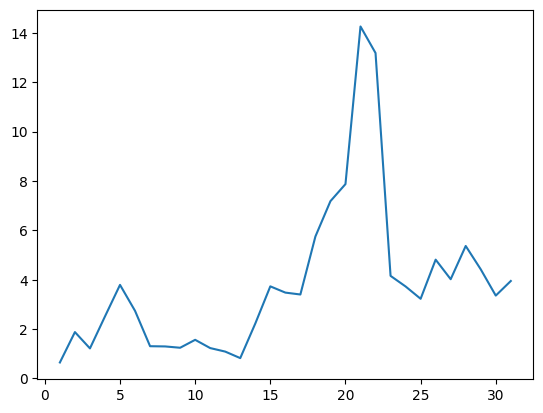

In [498]:
# Part (ii)

# Initialize data
X = np.array([[1], [2], [3], [4], [5]])
Y = np.array([[1], [0], [0]])

_, grads = run_dnn_model(X, Y, [], [], hl_count = 30, n_h = 10, epoch_number = 1, batch_size = 1, learning_rate = 0)

plot_grads(grads)

## Part (ii)

### Explanation: 

In [499]:
# Part (iii)  

# Load the CSV file
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv', )

# Extract labels and features
features = data.drop('Diabetes_012', axis = 1)
labels = data['Diabetes_012']
one_hot_labels = get_one_hot(labels, 3)

X_train, X_test, y_train, y_test = train_test_split(features, one_hot_labels, test_size = 0.2, random_state = 42)
X_train = X_train.T.values
X_test = X_test.T.values
y_train = y_train.T
y_test = y_test.T

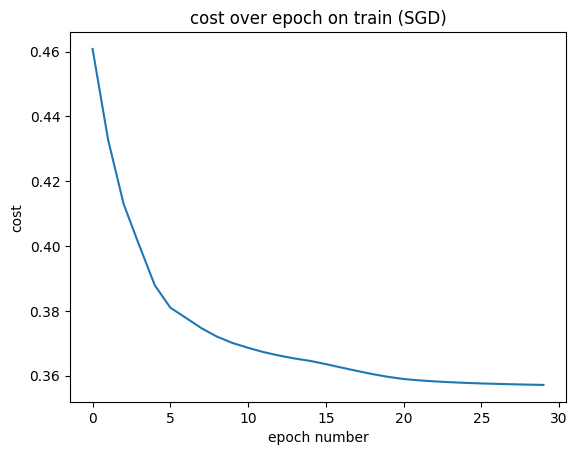

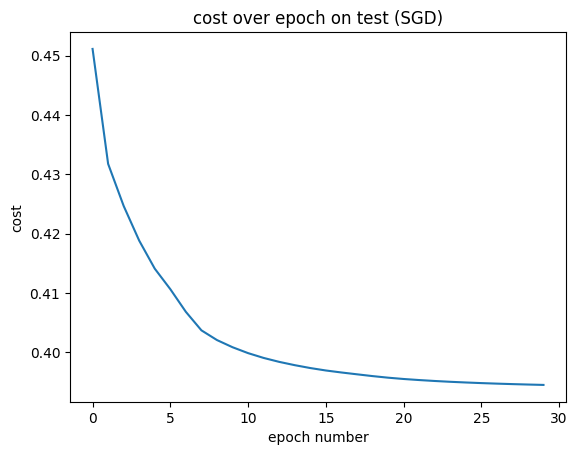

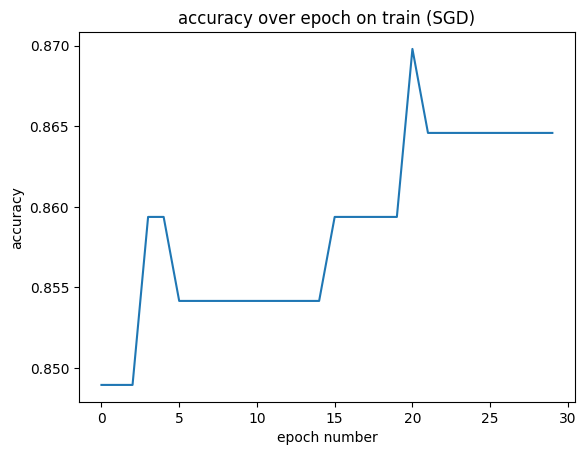

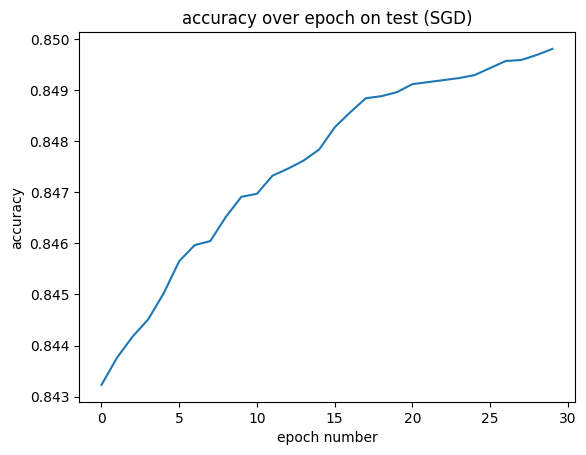

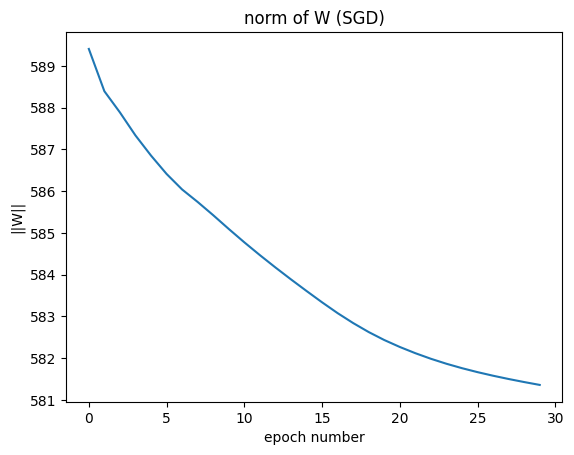

In [500]:
# Part (iii)

optimized_parameters = run_dnn_model(X_train, y_train, X_test, y_test,
                                     hl_count = 5, n_h = 10, 
                                     epoch_number = 30, batch_size = 256, learning_rate = 0.005, momentum_v = 0.9,
                                     gd_type = "SGD", enable_plot = True)